# US Arrests PCA Report

## Exploring the data

In [68]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Read the data and preview.
df = pd.read_csv("USArrests.csv", index_col="City")
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


## Distribution of data

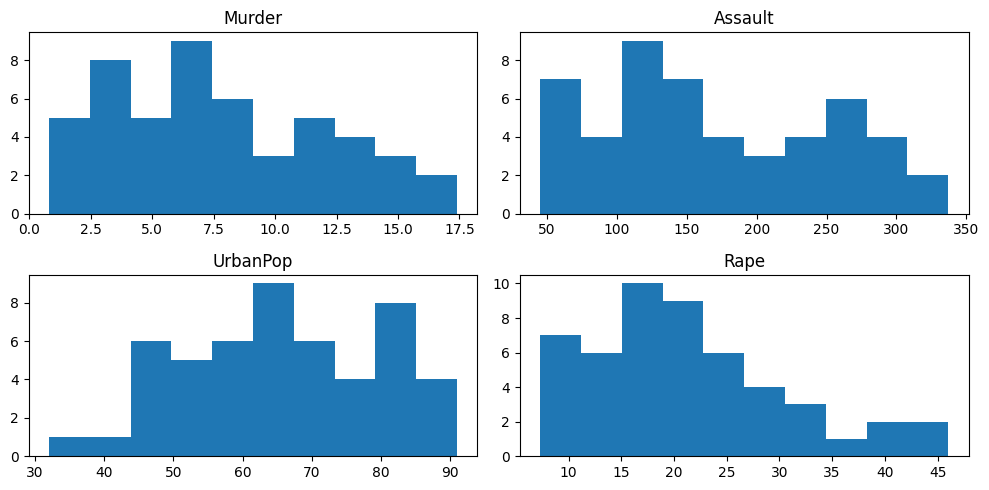

In [2]:
# Plot some histograms to see the spread of the data in each category.
histograms = df.hist(grid=False, figsize=(10, 5))
plt.tight_layout()
plt.show()

Based on the histograms, it would seem that the distribution of data does not follow any particular pattern, although the Rape category has the most consistent downwards trending curve. Normally you would expect a bit more of a bell-shaped curve, but this does not appear to be the case here.

## Crimes based on Urban Population Percentage

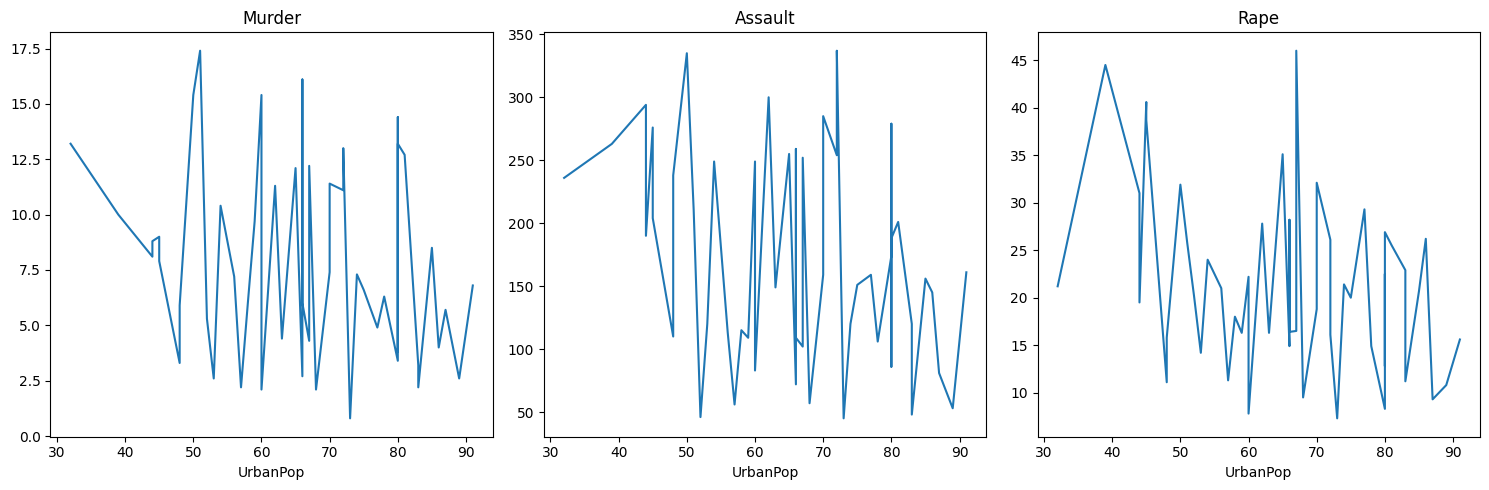

In [3]:
# Plot the crimes based on the urban population.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, crime in enumerate(["Murder", "Assault", "Rape"]):
    ax[i].plot(df[["UrbanPop"]].sort_values(by=["UrbanPop"]).values, df[crime].values)
    ax[i].set_xlabel("UrbanPop")
    ax[i].set_title(crime)

# Display
plt.tight_layout()
plt.show()

It would seem that based on the urban population alone, there isn't really a correlation with the crimes vs the urban population size.

## Scale data

Scale the data so that the numbers are easier for our models to work with later. We can see from the plots here that the shape of the data is not influenced by the scaling, which is what we want. Scaling should be most appropriate here as the data is already per 100,000 residents and percentage population, so we don't want to skew it too much.

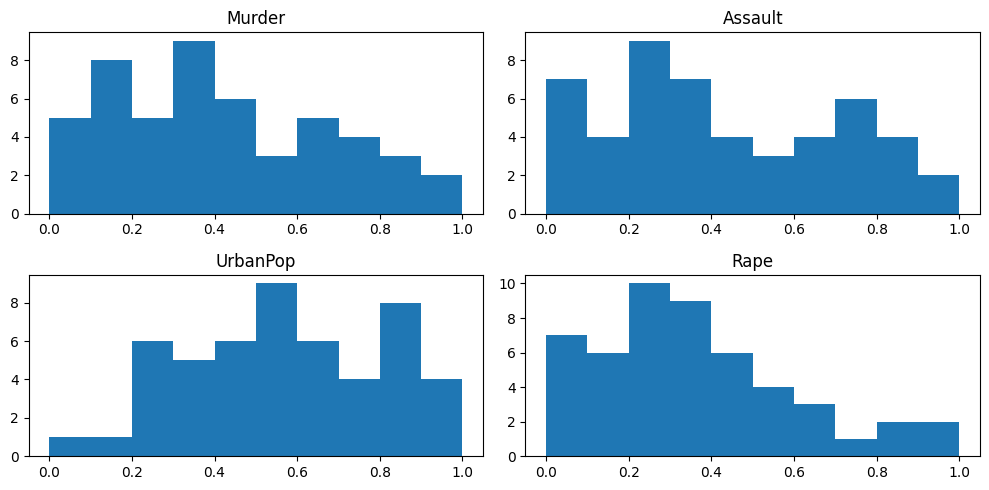

In [4]:
# Scale the data, creating a new df to use when we need it.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data)
scaled_df.rename(columns={0: "Murder", 1: "Assault", 2: "UrbanPop", 3: "Rape"}, inplace=True)
scaled_df.head()

# Plot some histograms to see the spread of the data in each category now that its scaled.
histograms = scaled_df.hist(grid=False, figsize=(10, 5))
plt.tight_layout()
plt.show()

## Correlations between features

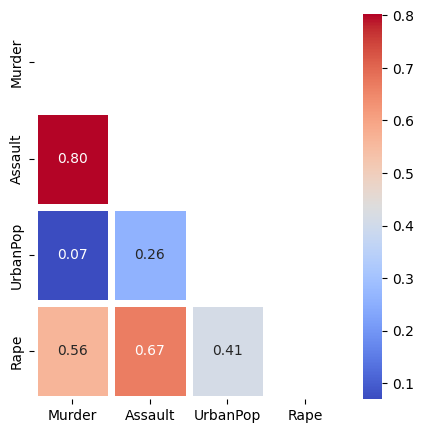

In [5]:
# Drop rows with missing values
df_pca = df.copy()

# Standardize features
standardised_data = StandardScaler().fit_transform(df_pca.values)

# Get correlations
corrs = df_pca.corr()

# Mask mirrored side of heatmap
drop_self = np.zeros_like(corrs)
drop_self[np.triu_indices_from(drop_self)] = True

# Plot figsize
fig, ax = plt.subplots(figsize=(5, 5))

# Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
ax = sns.heatmap(corrs, cmap="coolwarm", annot=True, fmt=".2f", mask=drop_self, linewidth=5)

# Display
plt.show()

The heatmap here suggests that the UrbanPop column has the least influence, whilst Assault has the biggest influence in a positive direction.

## Apply PCA

In [6]:
# choose number of components to be generated
nr_comps = 4
pca = PCA(n_components=nr_comps)

# Obtain components
principal_components = pca.fit_transform(standardised_data)

# Plot to a dataframe again. 
components = pd.DataFrame(pca.components_, columns=df.columns, index=range(1, 4+1)).transpose()
components

,1,2,3,4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


We can see here that the data seems to contribute reasonably evenly overall, so I'm happy to continue with clustering using this standardisation.

## Hierarchical clustering

I will first try out 3 methods of hierarchical clustering to see which gives us the best distribution.

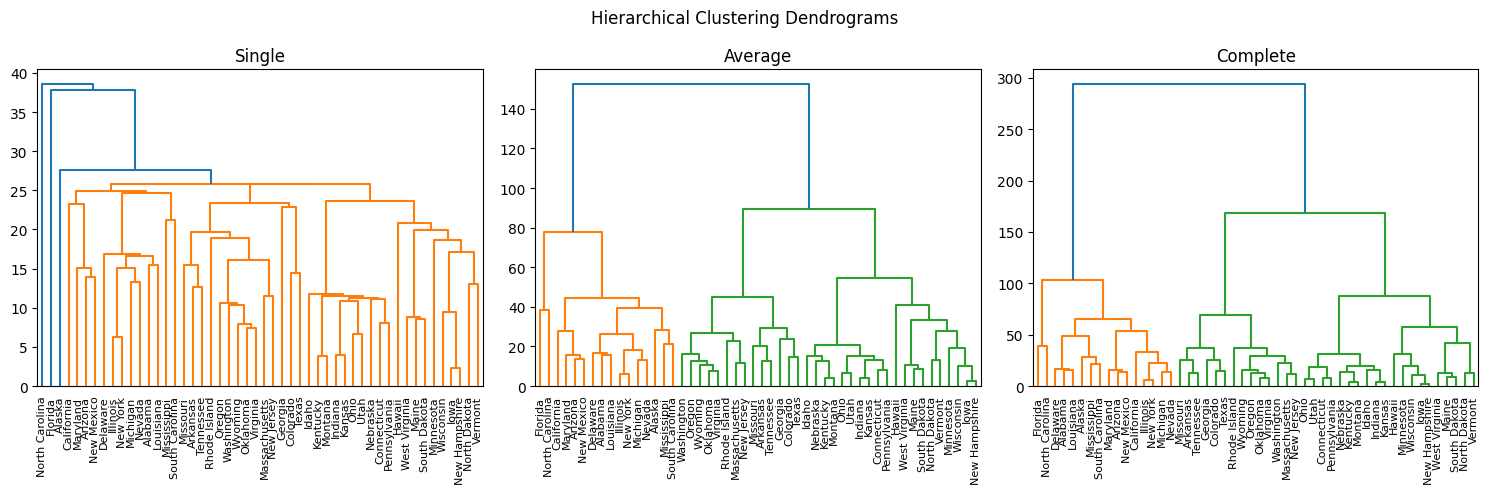

In [14]:
# Create a clustering model for Hierarchica
hierarchical_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical_model = hierarchical_model.fit(df_pca)

# Create a figure for plots of each dendrogram method.
h_fig, h_ax = plt.subplots(1, 3, figsize=(15, 5))

# Create subtitle for the figure.
h_fig.suptitle("Hierarchical Clustering Dendrograms")

# Plot the dendrograms for each method ("single", "average", "complete") to assess which is best.
for i, method in enumerate(["single", "average", "complete"]):
    # Plot dendrogram to graph.
    dendrogram(linkage(df_pca, method=method), labels=df_pca.index, ax=h_ax[i])
    
    # Set current graph title
    h_ax[i].set_title(method.capitalize())

# Display
plt.tight_layout()
plt.show()

Based on these dendrograms, it's a close call between Average and Complete, but I'm going to go with Complete as it begins to make larger clusters more quickly than Average. It's also quite evenly spread around 50, so should make for some tidier groups.

In [17]:
# Create the final model with chosen method.
final_model = AgglomerativeClustering(n_clusters=5, affinity="manhattan", linkage="complete")
final_model.fit_predict(scaled_data)

array([1, 3, 4, 0, 3, 3, 0, 0, 4, 1, 0, 0, 4, 0, 2, 0, 0, 1, 2, 4, 0, 3,
       2, 1, 0, 0, 0, 3, 2, 0, 4, 4, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 4, 0,
       2, 0, 0, 2, 2, 0], dtype=int64)

In [20]:
# Get the silhouette score.
us_silhouette_score = silhouette_score(scaled_data, final_model.labels_, metric="manhattan")
print("Silhouette Score:")
print(us_silhouette_score)

Silhouette Score:
0.302278206422949


The silhouette score of this model would mean that it is pretty average, but not as accurate as it could be. Time to try K-means clustering.

## K-means clustering

Try getting different combinations of features to see which ones give the best result. I will use a number of clusters of 4, as this seemed to be the a good number based on the hierarchical clustering.

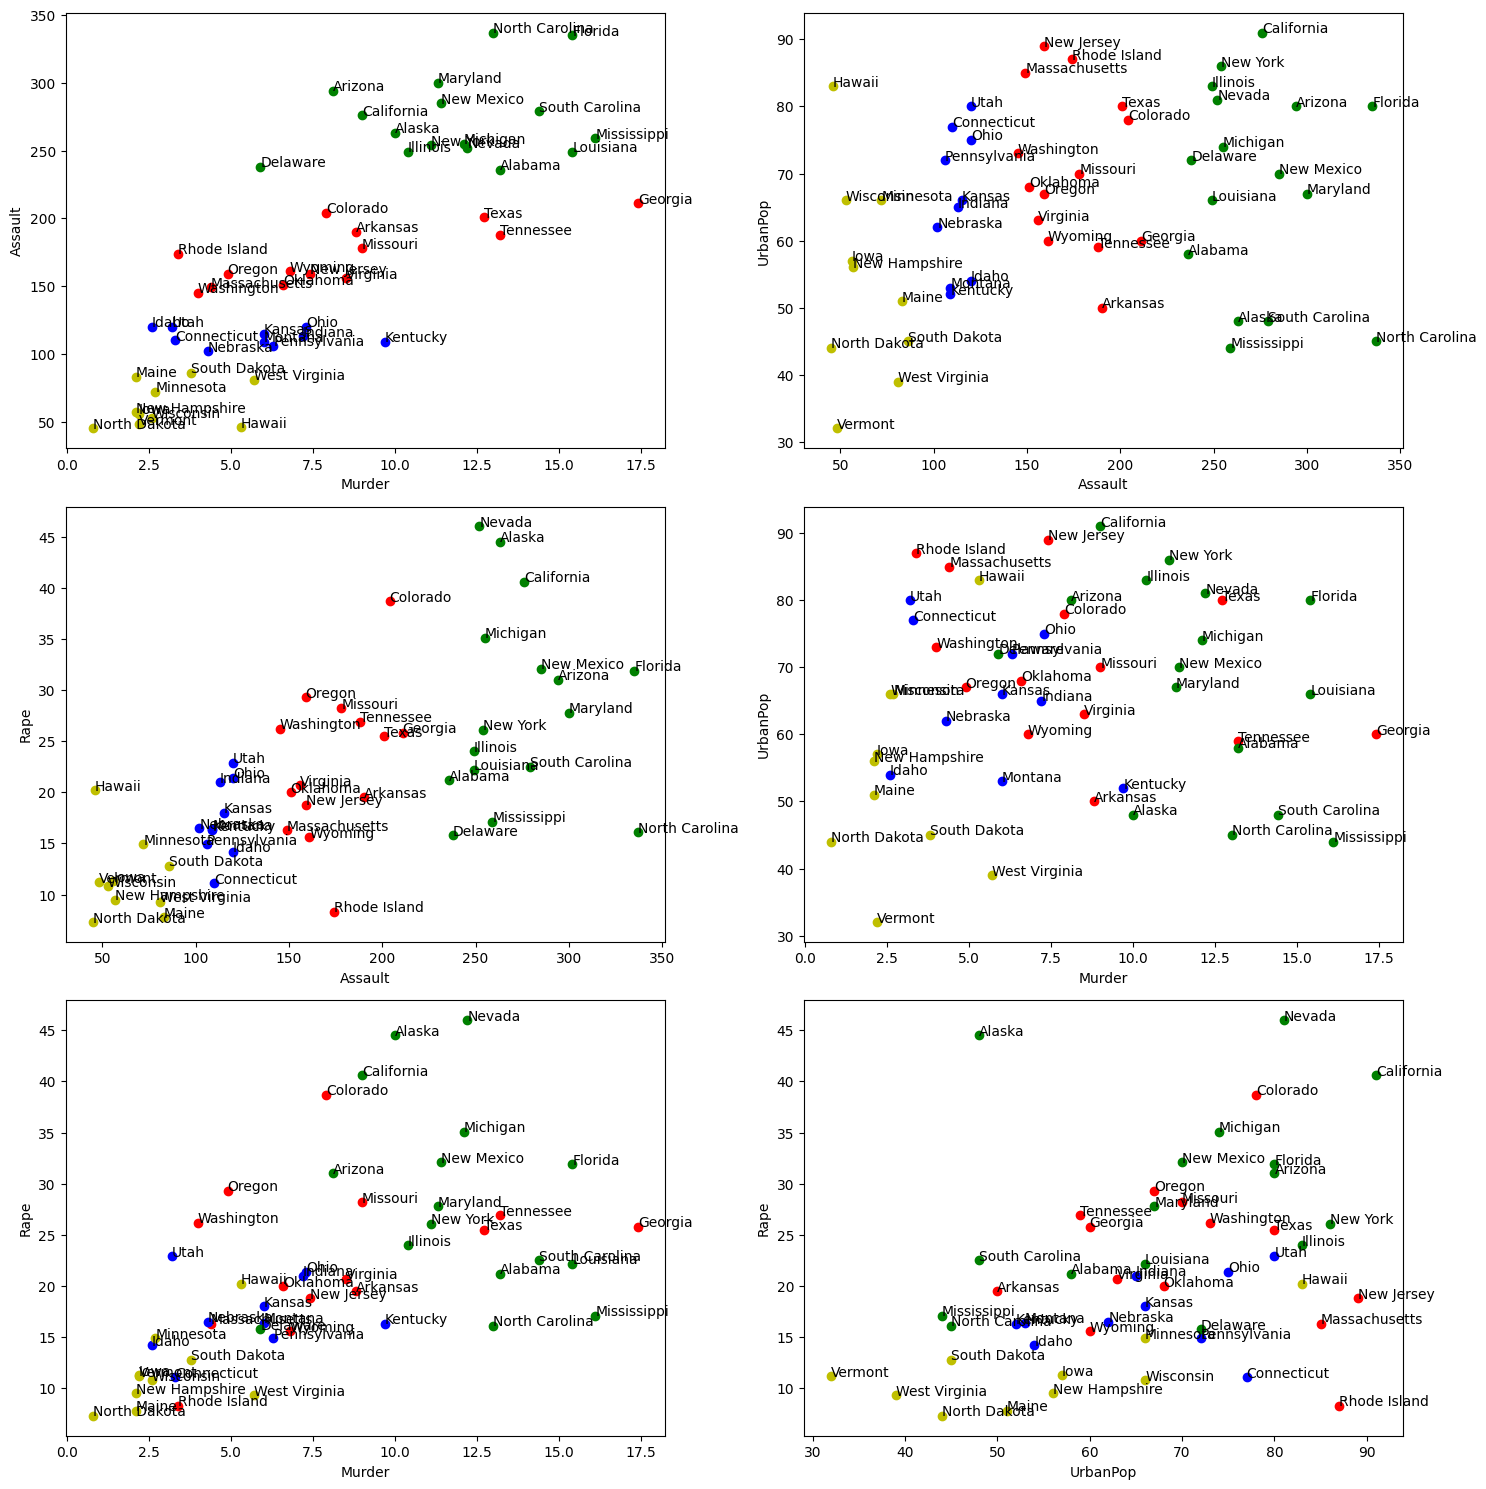

In [55]:
# Get each possible combination (except for final column)
column_combinations = list(itertools.combinations(range(4), 2))

# Colour combinations
colours = "rbgy"

# Get list of countries
countries = df.index

# Set n_clusters k value to 4.
k = 4

# Create a 3x2 grid to plot on.
k_fig, k_axs = plt.subplots(3, 2, figsize=(15, 15))
x = 0
y = 0

# Loop through each possible combination of columns and scatter plot.
for col_combo in column_combinations:
    if col_combo[0] != col_combo[1]:
        # Set the x/ y labels.
        k_axs[x][y].set_xlabel(df.columns.values.tolist()[col_combo[0]])
        k_axs[x][y].set_ylabel(df.columns.values.tolist()[col_combo[1]])
        
        # Extract the two feature combinations, if they're not the same.
        x_feature = df.iloc[:, col_combo[0]]
        y_feature = df.iloc[:, col_combo[1]]

        # Fit k-means
        kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
        cluster_labels = kmeans.fit_predict(df_pca)
        cent = kmeans.cluster_centers_

        # Plot clusters
        for i in range(0, k):
            k_axs[x][y].scatter(x_feature[cluster_labels == i], y_feature[cluster_labels == i], c=colours[i]) 

        for i in range(0, len(x_feature)):
                txt = countries[i]
                k_axs[x][y].annotate(txt, (x_feature[i], y_feature[i]))
                
        # Count the X/Y axis of the grid to get a 3x2 grid.
        if x < 2:
            x+=1
        else:
            x = 0
        if y < 1:
            y+=1
        else:
            y = 0
        
# Display
plt.tight_layout()
plt.show()

Based on these plots, I feel that the UrbanPop vs Assault or UrbanPop vs Murder charts were quite well spread out. 
I will choose UrbanPop vs Assault as there was less crossover in the clusters here overall. For this, I will also print the names in a readable list of clusters.

In [66]:
# Groups - translate to readable names
clusters = pd.DataFrame()

# Extract the two feature combinations (UrbanPop and Assault)
X_final = df[["UrbanPop", "Assault"]].values.reshape(-1, 2)

# Create the final model
kmeans_final = KMeans(n_clusters=k, init='k-means++', random_state=42)
y_pred_final = kmeans_final.fit_predict(X_final)

for i in range(4):
    group_indices = np.argwhere(y_pred_final==i).transpose()[0]
    group = np.array(countries)[group_indices]
    print("Group {}".format(i))
    print(group)
    print("\n")

Group 0
['Arkansas' 'Colorado' 'Georgia' 'Massachusetts' 'Missouri' 'New Jersey'
 'Oklahoma' 'Oregon' 'Rhode Island' 'Tennessee' 'Texas' 'Virginia'
 'Washington' 'Wyoming']


Group 1
['Connecticut' 'Idaho' 'Indiana' 'Kansas' 'Kentucky' 'Montana' 'Nebraska'
 'Ohio' 'Pennsylvania' 'Utah']


Group 2
['Alabama' 'Alaska' 'Arizona' 'California' 'Delaware' 'Florida' 'Illinois'
 'Louisiana' 'Maryland' 'Michigan' 'Mississippi' 'Nevada' 'New Mexico'
 'New York' 'North Carolina' 'South Carolina']


Group 3
['Hawaii' 'Iowa' 'Maine' 'Minnesota' 'New Hampshire' 'North Dakota'
 'South Dakota' 'Vermont' 'West Virginia' 'Wisconsin']




In [75]:
# Get the silhouette score.
silhouette_score_kmeans = round(silhouette_score(X_final, kmeans_final.labels_, metric="euclidean"), 2)
print("Silhouette Score:")
print(silhouette_score_kmeans)

Silhouette Score:
0.52


The silhouette score is slightly higher than the hierarchical model, meaning that it is probably a better fit for working with this dataset overall. Plotting the various combinations of data in the k-means model made for some interesting grouping, particularly for Alaska, which appeared to be an outlier in the Rape feature when associated with its UrbanPop.